In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import Tracks, DenseNetwork, set_seed
import os

In [5]:
seed = 101
name = 'network_06'
tracks = 'tracks_04b'
save_path = f'/home/ADF/ajl573/Data/interstellar_data/{name}'
load_path = f'/home/ADF/ajl573/Data/interstellar_data/{tracks}'

In [6]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [7]:
train = pd.read_csv(f'{load_path}/{tracks}_train.csv')

## Resample

Let's try to resample 80% of the dataset

In [8]:
0.8 * len(train)

6188586.4

For simplicity and batching, I will round this down to 6 million points.

In [9]:
t = Tracks(name=tracks)
t.set_data(train.sample(n=6000000, weights='gradient', random_state=seed))

del train

In [10]:
t.get_data().head()

,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,frac_age,effective_T,luminosity,log_g,surface_he4,surface_Z,star_feh,delta_nu_fit,initial_Zinit,gradient,log_star_age,log_radius
3995955,2,1.08,0.30,0.35,1.9,1.043595,5673.275,1.826398,4.178337,0.259003,0.024350,0.273529,86.067856,0.027260,0.000320,0.870810,0.146389
4415608,2,1.20,0.26,0.25,1.9,1.155536,5632.717,2.945005,4.003852,0.226761,0.020889,0.185828,62.464220,0.023076,0.001583,0.843099,0.256366
219821,2,0.94,0.26,0.25,2.3,1.260279,4816.204,2.492565,3.697376,0.255329,0.022432,0.235659,38.246070,0.023076,0.000526,1.276368,0.356172
1326105,2,0.97,0.24,0.25,2.3,1.184105,5254.683,1.341456,4.131911,0.210687,0.021564,0.190855,81.709206,0.023699,0.001516,1.268245,0.145954
5302363,2,0.80,0.24,-0.10,2.3,1.186145,4891.288,2.689784,3.620810,0.232189,0.010325,-0.121725,34.789745,0.010772,0.000489,1.412521,0.359271


In [11]:
len(t._data)

6000000

## Normalize

Let's choose the inputs and outputs and the normalise

In [12]:
x_cols = ['frac_age', 'initial_mass', 'initial_MLT', 'initial_Yinit', 'initial_Zinit']
y_cols = ['log_star_age', 'effective_T', 'log_radius', 'delta_nu_fit', 'star_feh']

In [13]:
factors, _df = t.normalize(loc='mean', scale='std', columns=x_cols+y_cols)

In [14]:
factors

,column,norm_column,loc,scale
0,frac_age,frac_age_norm,0.886590,0.402850
1,initial_mass,initial_mass_norm,0.996833,0.119499
2,initial_MLT,initial_MLT_norm,1.997272,0.338006
3,initial_Yinit,initial_Yinit_norm,0.280062,0.028064
4,initial_Zinit,initial_Zinit_norm,0.018318,0.010699
5,log_star_age,log_star_age_norm,0.784033,0.450751
6,effective_T,effective_T_norm,5528.783927,605.919601
7,log_radius,log_radius_norm,0.142940,0.149972
8,delta_nu_fit,delta_nu_fit_norm,92.475003,42.530333
9,star_feh,star_feh_norm,-0.017718,0.357204


Round the loc and scale to 3 dp

In [15]:
factors = round(factors, 3)

In [16]:
factors

,column,norm_column,loc,scale
0,frac_age,frac_age_norm,0.887,0.403
1,initial_mass,initial_mass_norm,0.997,0.119
2,initial_MLT,initial_MLT_norm,1.997,0.338
3,initial_Yinit,initial_Yinit_norm,0.280,0.028
4,initial_Zinit,initial_Zinit_norm,0.018,0.011
5,log_star_age,log_star_age_norm,0.784,0.451
6,effective_T,effective_T_norm,5528.784,605.920
7,log_radius,log_radius_norm,0.143,0.150
8,delta_nu_fit,delta_nu_fit_norm,92.475,42.530
9,star_feh,star_feh_norm,-0.018,0.357


In [17]:
factors, _df = t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols)
_df.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
3995955,0.388573,0.697479,-0.286982,0.714286,0.841818,0.192484,0.238465,0.022593,-0.150650,0.816607
4415608,0.666342,1.705882,-0.286982,-0.714286,0.461413,0.131040,0.171529,0.755774,-0.705638,0.570948
219821,0.926252,-0.478992,0.896450,-0.714286,0.461413,1.091725,-1.176030,1.421149,-1.275075,0.710530
1326105,0.737234,-0.226891,0.896450,-1.428571,0.518110,1.073714,-0.452372,0.019693,-0.253134,0.585029
5302363,0.742295,-1.655462,0.896450,-1.428571,-0.657099,1.393617,-1.052112,1.441808,-1.356343,-0.290547


In [18]:
del _df

In [19]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols, inplace=True)

In [20]:
factors.to_csv(os.path.join(save_path, 'tracks_04b_norm.csv'), index=False)

In [21]:
train = t.get_data([f'{col}_norm' for col in x_cols+y_cols])
train.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
3995955,0.388573,0.697479,-0.286982,0.714286,0.841818,0.192484,0.238465,0.022593,-0.150650,0.816607
4415608,0.666342,1.705882,-0.286982,-0.714286,0.461413,0.131040,0.171529,0.755774,-0.705638,0.570948
219821,0.926252,-0.478992,0.896450,-0.714286,0.461413,1.091725,-1.176030,1.421149,-1.275075,0.710530
1326105,0.737234,-0.226891,0.896450,-1.428571,0.518110,1.073714,-0.452372,0.019693,-0.253134,0.585029
5302363,0.742295,-1.655462,0.896450,-1.428571,-0.657099,1.393617,-1.052112,1.441808,-1.356343,-0.290547


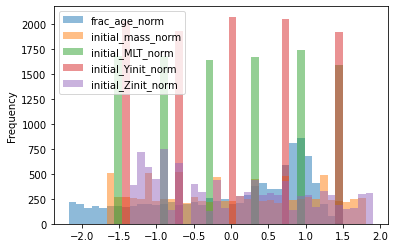

In [24]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in x_cols],
                           bins=40, alpha=0.5)

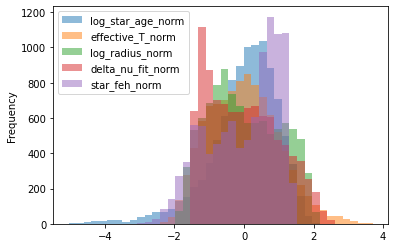

In [25]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in y_cols], bins=40, alpha=0.5)

Validation

In [26]:
val = pd.read_csv(f'{load_path}/{tracks}_val.csv')

In [27]:
t = Tracks()
t.set_data(val)

In [28]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
            columns=x_cols+y_cols, inplace=True)

In [29]:
val = t.get_data([f'{col}_norm' for col in x_cols+y_cols])
val.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
0,-2.144928,0.02521,0.89645,-1.428571,-0.657099,-3.267303,0.389481,-1.339923,1.706118,-0.236674
1,-2.055016,0.02521,0.89645,-1.428571,-0.657099,-2.345807,0.403000,-1.312313,1.651492,-0.249146
2,-2.020283,0.02521,0.89645,-1.428571,-0.657099,-2.140266,0.408372,-1.302933,1.633083,-0.253994
3,-2.013346,0.02521,0.89645,-1.428571,-0.657099,-2.103994,0.409448,-1.301084,1.629465,-0.254954
4,-1.985631,0.02521,0.89645,-1.428571,-0.657099,-1.971340,0.413739,-1.293744,1.615137,-0.258766


In [30]:
del t

In [31]:
x_cols = [f'{col}_norm' for col in x_cols]
y_cols = [f'{col}_norm' for col in y_cols]

In [32]:
print(f'Length of training data = {len(train)}')
print(f'Length of validation data = {len(val)}')

Length of training data = 6000000
Length of validation data = 1933933


In [33]:
n_batches = np.arange(500, 2000)  # Select a range where number of batches is reasonable
r = (len(train)) % n_batches 

# Print whole multiples of training size
print(f'choose number of batches from:\n{n_batches[r==0]}')

choose number of batches from:
[ 500  600  625  640  750  800  960 1000 1200 1250 1500 1600 1875 1920]


In [34]:
depth = 5
width = 128
activation = 'elu'
batch_size = len(train)//600
regularization_l2 = 1e-8
optimizer = 'nadam'
loss = 'mse'
metrics = ['mae']

In [35]:
network = DenseNetwork(path=save_path, name=name, depth=depth, width=width,
                       activation=activation, batch_size=batch_size, regularization_l2=regularization_l2)

In [36]:
network.build(len(x_cols), len(y_cols))

In [37]:
network.compile(optimizer=optimizer, loss=loss, metrics=metrics)
network.save()

In [ ]:
network.train(train, x_cols, y_cols, epochs=5000, validation_split=None, validation_data=val,
              callbacks=['checkpoint', 'tensorboard'])

In [ ]:
network.save()

In [ ]:
network.plot_metric(val.sample(20000), metric='absolute_error');

In [ ]:
network.plot_metric(val.sample(20000), metric='error');

In [43]:
network.scores(val.sample(20000))

,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
count,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04
mean,3.587124e-03,6.930733e-03,1.256891e-02,1.174061e-02,4.330983e-03
std,3.845735e-03,9.643019e-03,1.232732e-02,8.343640e-03,4.183544e-03
min,2.817440e-07,5.516758e-07,2.783326e-07,3.654741e-07,2.010305e-07
25%,1.245150e-03,1.764783e-03,5.385224e-03,5.293891e-03,1.558304e-03
50%,2.691089e-03,3.890736e-03,1.021531e-02,1.080576e-02,3.333610e-03
75%,4.782309e-03,7.796045e-03,1.587089e-02,1.707032e-02,5.908990e-03
max,8.209165e-02,1.907045e-01,2.724186e-01,1.681495e-01,9.281813e-02


In [45]:
factors.loc[5:, 'scale'].to_numpy() * network.scores(val.sample(20000), metric='error')

,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
count,9020.000000,1.211840e+07,3000.000000,850600.000000,7140.000000
mean,-0.000551,-9.208020e-01,-0.000659,0.286587,0.000238
std,0.002305,7.261139e+00,0.002689,0.556314,0.002096
min,-0.030846,-1.152964e+02,-0.020478,-7.308614,-0.029378
25%,-0.001641,-2.504666e+00,-0.001989,-0.014470,-0.000806
50%,-0.000353,-6.999010e-02,-0.001106,0.354291,0.000428
75%,0.000819,2.172681e+00,0.000103,0.672810,0.001379
max,0.010464,4.779215e+01,0.055771,2.418060,0.025884
